In [2]:
using CSV, DataFrames, CategoricalArrays, Statistics, StatsPlots
function fit_learner(model_name,X, y, t)
    println("initial columns of X: ", names(X))

    # List of column names to exclude if they exist
    columns_to_ignore = [:TBS_binary, :CEA_binary_200, Symbol("DFI.12"), :CEA_binary_20, :number_binary, :size_binary]
    # Filter the list to include only columns that exist in the DataFrame
    columns_to_ignore = filter(col -> col in names(X), columns_to_ignore)
    println("columns_to_ignore: ", columns_to_ignore)
    # Exclude the selected columns from X
    X = X[:, Not(columns_to_ignore)]    
    println("training columns of X: ", names(X))
    train_auc = []
    test_harrell = []
    lnrs = []
    for seed in 1:1
        # split AGAIN on input (training) data
        (train_X, train_y, train_t), (test_X,test_y, test_t) = IAI.split_data(:survival, X, y,t, seed=123, train_proportion=0.7)
        println("diff train_y-test_y: ", mean(train_y)-mean(test_y))
        println("diff train_t -test_t:", mean(train_t)- mean(test_t))
        
        #for seed = 3
        grid = IAI.GridSearch(
        IAI.OptimalTreeSurvivalLearner(
            random_seed=1,
            missingdatamode=:separate_class,
            minbucket=15,max_depth=6
        )#,minbucket=[15,20],max_depth=3:5,
        
            )
        IAI.fit!(grid, train_X, train_y, train_t, validation_criterion=:harrell_c_statistic)
        lnr=IAI.get_learner(grid)
        push!(train_auc, IAI.score(lnr, test_X, test_y, test_t, criterion=:auc, evaluation_time=12*5))
        push!(test_harrell, IAI.score(lnr, test_X, test_y, test_t, criterion=:harrell_c_statistic))
        push!(lnrs, lnr)
    end
    
    #end 
    best_lnr = lnrs[argmax(test_harrell)]
    println("mean inner validation AUC: ",mean(train_auc), "max inner validation AUC: ", maximum(train_auc))
    println("mean inner validation Harrel C: ",mean(test_harrell), "max inner validation Harrell C: ", maximum(test_harrell))
    return best_lnr
end
  

fit_learner (generic function with 1 method)

In [7]:
data = CSV.read("traindata/unmatched_train_data.csv", DataFrame) 
display(data)
#val_data = CSV.read("testdata_main/test_data.csv", DataFrame)


train_X = data[:,Not([:died,:time_to_event])] # for model 1 we train with adjuvantchemo as covariate!
train_y = data.died .== 1
train_t = data.time_to_event./ 30.44
#val_X = val_data[:,Not([:died,:time_to_event])]
#train_y  = val_data.died .== 1
#train_t  = val_data.time_to_event./ 30.44

train_X_untreated = train_X[train_X."adjuvantchemo".==0,Not(:adjuvantchemo)]
train_y_untreated  = train_y[train_X."adjuvantchemo".==0]
train_t_untreated  = train_t[train_X."adjuvantchemo".==0];
# train on treated patient another model
train_X_treated =  train_X[train_X."adjuvantchemo".==1,Not(:adjuvantchemo)]
train_y_treated  = train_y[train_X."adjuvantchemo".==1]
train_t_treated  = train_t[train_X."adjuvantchemo".==1];

#=train_X = val_X[val_X."adjuvantchemo".==0,Not(:adjuvantchemo)]
train_y_untreated  = train_y[val_X."adjuvantchemo".==0]
val_t_untreated  = train_t[val_X."adjuvantchemo".==0];

val_X_treated = val_X[val_X."adjuvantchemo".==1,Not(:adjuvantchemo)]
train_y_treated  = train_y[val_X."adjuvantchemo".==1]
val_t_treated  = train_t[val_X."adjuvantchemo".==1];
=#

Row,age,size,cea_carcinoembryonic.antigen,number_liver_mets,DFI.12,T_stage,N_stage,rightleft.Rec,extrahepatic.disease,R0,KRAS,adjuvantchemo,died,time_to_event
,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64
1,61.0,0.4,6.3,1.0,0,2,0,2,0,1,1,0,1,1454.91
2,58.0,4.0,1.4,4.0,0,3,0,0,1,0,1,1,0,1104.88
3,48.0,4.0,153.0,1.0,0,3,0,2,1,1,1,1,1,535.7
4,32.0,1.0,3.0,2.0,1,2,1,2,1,0,1,1,0,995.306
5,65.0,3.0,43.1,2.0,0,3,0,1,1,0,1,1,0,508.306
6,56.0,2.9,7.9,1.0,0,4,1,0,1,0,1,0,0,1031.83
7,58.0,2.7,34.4,3.0,0,4,0,0,1,0,1,0,1,815.725
8,75.0,4.0,93.7,1.0,0,2,0,0,1,0,1,0,1,368.294
9,58.0,2.3,120.0,1.0,0,3,1,0,1,0,1,0,0,118.706


In [5]:
table = DataFrame(Model = "", test_AUC = [], test_Harrell_C= [])


Row,Model,test_AUC,test_Harrell_C
,String,Any,Any


## MODEL 1: trained on entire training (70%) dataset BEFORE matching & evaluate on entire validation set


In [4]:

tree1 = fit_learner("Model 1",train_X, train_y, train_t) 
table

initial columns of X: ["age", "size", "cea_carcinoembryonic.antigen", "number_liver_mets", "DFI.12", "T_stage", "N_stage", "rightleft.Rec", "extrahepatic.disease", "R0", "KRAS", "adjuvantchemo"]
columns_to_ignore: Symbol[]
training columns of X: ["age", "size", "cea_carcinoembryonic.antigen", "number_liver_mets", "DFI.12", "T_stage", "N_stage", "rightleft.Rec", "extrahepatic.disease", "R0", "KRAS", "adjuvantchemo"]
diff train_y-test_y: 0.027880740152384342
diff train_t -test_t:0.13062293108830403


[ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.


mean inner validation AUC: 0.6832000841573743max inner validation AUC: 0.6832000841573743
mean inner validation Harrel C: 0.6173858501190324max inner validation Harrell C: 0.6173858501190324


LoadError: UndefVarError: `table` not defined

In [8]:
train_auc=IAI.score(tree1, train_X, train_y, train_t, criterion=:auc,
          evaluation_time=5*12)
train_harrell=IAI.score(tree1, train_X, train_y, train_t, criterion=:harrell_c_statistic)
#test_brier = IAI.score(tree1, val_X, train_y, train_t, criterion=:integratedbrier)
push!(table, ["Model 1", train_auc, train_harrell])



Row,Model,test_AUC,test_Harrell_C
,String,Any,Any
1,Model 1,0.728843,0.670626


In [10]:
using DataFrames

# Splitting the validation data based on the 'adjuvantchemo' variable
train_X_untreated = train_X[train_X."adjuvantchemo" .== 0, :]
train_X_treated = train_X[train_X."adjuvantchemo" .== 1, :]

# Define a function to check if a model name exists in the table
function model_exists_in_table(table::DataFrame, model_name::String)::Bool
    for row in eachrow(table)
        if row[1] == model_name
            return true
        end
    end
    return false
end

# Evaluate the model on untreated data
model_1a_name = "Model 1A"
model_1b_name = "Model 1B"
function record_score_to_table(table,model_name_A,model_name_B, tree1,tree2)
    if !model_exists_in_table(table, model_name_A)
        train_auc = IAI.score(tree1, train_X_untreated, train_y_untreated, train_t_untreated, criterion = :auc, evaluation_time = 5 * 12)
        train_harrell = IAI.score(tree1, train_X_untreated, train_y_untreated, train_t_untreated, criterion = :harrell_c_statistic)
        push!(table, (model_name_A, train_auc, train_harrell))
    end

    # Evaluate the model on treated data
    
    if !model_exists_in_table(table, model_name_B)
        train_auc = IAI.score(tree2, train_X_treated, train_y_treated, train_t_treated, criterion = :auc, evaluation_time = 5 * 12)
        test_harrell = IAI.score(tree2, train_X_treated, train_y_treated, train_t_treated, criterion = :harrell_c_statistic)
        push!(table, (model_name_B, train_auc, test_harrell))
    end
end
record_score_to_table(table, model_1a_name,model_1b_name,tree1,tree1)    
table    


Row,Model,test_AUC,test_Harrell_C
,String,Any,Any
1,Model 1,0.728843,0.670626
2,Model 1A,0.661559,0.638379
3,Model 1B,0.719503,0.665936


In [45]:
#predict 5 year probability of dying using model 1 on validation set
val_data[!,"ost_model1"] = 1 .- IAI.predict(tree1, val_X, t= 12*5);


## MODEL 2: train model on untreated patient dataset BEFORE matching and evaluate on untreated validation data only (2.1), id. on treated datasets (2.2)


In [11]:

tree2A = fit_learner("Model 2A",train_X_untreated,train_y_untreated, train_t_untreated)

tree2B = fit_learner("Model 2B",train_X_treated,train_y_treated, train_t_treated)


initial columns of X: ["age", "size", "cea_carcinoembryonic.antigen", "number_liver_mets", "DFI.12", "T_stage", "N_stage", "rightleft.Rec", "extrahepatic.disease", "R0", "KRAS", "adjuvantchemo"]
columns_to_ignore: Symbol[]
training columns of X: ["age", "size", "cea_carcinoembryonic.antigen", "number_liver_mets", "DFI.12", "T_stage", "N_stage", "rightleft.Rec", "extrahepatic.disease", "R0", "KRAS", "adjuvantchemo"]
diff train_y-test_y: 0.014278027847403507
diff train_t -test_t:-1.214226852482362


mean inner validation AUC: 0.5135902636916835max inner validation AUC: 0.5135902636916835
mean inner validation Harrel C: 0.5416666666666666max inner validation Harrell C: 0.5416666666666666
initial columns of X: ["age", "size", "cea_carcinoembryonic.antigen", "number_liver_mets", "DFI.12", "T_stage", "N_stage", "rightleft.Rec", "extrahepatic.disease", "R0", "KRAS", "adjuvantchemo"]
columns_to_ignore: Symbol[]
training columns of X: ["age", "size", "cea_carcinoembryonic.antigen", "number_liver_mets", "DFI.12", "T_stage", "N_stage", "rightleft.Rec", "extrahepatic.disease", "R0", "KRAS", "adjuvantchemo"]
diff train_y-test_y: -0.04870995406226525
diff train_t -test_t:-0.4007807978293272
mean inner validation AUC: 0.5496144480519481max inner validation AUC: 0.5496144480519481
mean inner validation Harrel C: 0.5736278250660405max inner validation Harrell C: 0.5736278250660405


Fitted OptimalTreeSurvivalLearner:
  1) Split: cea_carcinoembryonic.antigen < 8.05
    2) Split: size < 3.05
      3) Split: age < 43.5
        4) Expected survival: 247.4, 33 points, error 0.4042
        5) Split: size < 2.95
          6) Expected survival: 106.5, 211 points, error 0.5805
          7) Expected survival: 219, 34 points, error 0.3969
      8) Split: DFI.12 < 0.5
        9) Split: age < 59.5
          10) Expected survival: 209.9, 23 points, error 0.688
          11) Expected survival: 53.93, 29 points, error 0.7035
        12) Split: T_stage < 3.5
          13) Expected survival: 127.3, 62 points, error 0.5034
          14) Expected survival: 116, 26 points, error 0.5847
    15) Split: size < 2.05
      16) Split: N_stage < 0.5
        17) Split: rightleft.Rec < 0.5
          18) Expected survival: 272, 21 points, error 0.2038
          19) Expected survival: 86.95, 20 points, error 0.5888
        20) Split: age < 59.5
          21) Expected survival: 100.9, 45 points, error 0.5182
          22) Expected survival: 218.4, 23 points, error 0.2359
      23) Split: rightleft.Rec < 1.5
        24) Split: cea_carcinoembryonic.antigen < 10.8
          25) Expected survival: 67.27, 21 points, error 0.7359
          26) Split: age < 50.5
            27) Expected survival: 197.5, 43 points, error 0.4328
            28) Expected survival: 97.43, 162 points, error 0.5033
        29) Split: age < 63
          30) Expected survival: 89.63, 54 points, error 0.5061
          31) Split: number_liver_mets < 1.5
            32) Expected survival: 50.9, 16 points, error 0.5768
            33) Expected survival: 57.91, 15 points, error 1.112

In [12]:
record_score_to_table(table, "Model 2A","Model 2B",tree2A,tree2B)

Row,Model,test_AUC,test_Harrell_C
,String,Any,Any
1,Model 1,0.728843,0.670626
2,Model 1A,0.661559,0.638379
3,Model 1B,0.719503,0.665936
4,Model 2A,0.655233,0.63033
5,Model 2B,0.684698,0.648832


In [49]:

# add predictions to validation dataframe
val_data[!,"ost_model2"] = ones(length(train_y))
val_data[val_X."adjuvantchemo".==0,"ost_model2"] = 1 .- IAI.predict(tree2A, train_X, t= 5*12)
val_data[val_X."adjuvantchemo".==1,"ost_model2"] = 1 .- IAI.predict(tree2B, val_X_treated, t= 5*12)

val_data

Row,age,size,cea_carcinoembryonic.antigen,number_liver_mets,DFI.12,T_stage,N_stage,rightleft.Rec,extrahepatic.disease,R0,KRAS,adjuvantchemo,died,time_to_event,TBS_binary,CEA_binary_200,CEA_binary_20,number_binary,size_binary,ost_model1,ost_model2
,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Float64
1,48.0,4.0,153.0,1.0,0,3,0,2,1,1,1,1,1,535.7,1,0,1,0,0,0.487255,0.70046
2,58.0,2.7,34.4,3.0,0,4,0,0,1,0,1,0,1,815.725,1,0,1,1,0,0.237266,0.210348
3,32.0,1.0,3.0,5.0,1,2,1,2,1,0,1,1,0,980.087,1,0,0,1,0,0.613658,0.935345
4,64.0,5.0,7.4,3.0,0,3,1,1,1,0,1,1,0,203.931,1,0,0,1,1,0.627325,0.611969
5,48.0,7.5,81.1,5.0,1,4,1,1,0,0,1,1,0,313.506,1,0,1,1,1,0.330499,0.651152
6,53.0,3.52716,71.2952,1.0,0,3,1,1,0,0,1,1,0,1165.76,1,0,1,0,0,0.627325,0.219096
7,19.0,3.0,2.3,2.0,1,4,1,0,1,0,1,1,1,733.544,1,0,0,1,0,0.966667,0.935345
8,67.0,4.0,8.0,6.0,0,3,1,0,0,0,1,1,0,791.375,1,0,0,1,0,0.330499,0.611969
9,55.0,3.43903,13.4,1.0,1,4,1,0,0,0,1,1,0,1881.04,1,0,0,0,0,0.415091,0.359786


# Model 3

In [19]:
data_3A = CSV.read("traindata/equalized_traindata/matched_train_equalized_r1.0.csv", DataFrame) 
X_3A = data_3A[:,Not([:dying_prob_5y,:risk_bucket,:adjuvantchemo,:died,:time_to_event,Symbol("DFI.12")])] # exclude risk_proba, chemo, OS, OSstatus columns
y_3A = data_3A."died" .==1
t_3A = data_3A."time_to_event"./ 30.44

data_3B = CSV.read("traindata/equalized_traindata/matched_train_equalized_r1.0.csv", DataFrame) 
X_3B = data_3B[:,Not([:dying_prob_5y,:risk_bucket,:adjuvantchemo,:died,:time_to_event,Symbol("DFI.12")])] # exclude risk_proba, chemo, OS, OSstatus columns
y_3B = data_3B."died" .==1
t_3B = data_3B."time_to_event"./ 30.44
X_3B

Row,age,size,cea_carcinoembryonic.antigen,number_liver_mets,T_stage,N_stage,rightleft.Rec,extrahepatic.disease,R0,KRAS
,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64
1,63.0,4.5,1.6,1.0,4,1,1,0,0,0
2,61.0,3.42733,7.0,5.0,3,1,2,0,0,0
3,57.0,4.0,42.0,1.0,3,1,0,0,0,0
4,56.0,3.7,30.0,1.0,3,1,0,0,0,0
5,66.0,3.48884,50.563,1.0,3,1,1,0,0,0
6,66.0,3.43833,17.0,1.0,3,1,1,0,0,0
7,79.0,3.41789,8.0,2.0,4,1,1,0,0,0
8,73.0,2.3,2.4,1.0,3,0,0,0,0,1
9,74.0,3.41284,3.0,1.0,3,1,1,0,0,0


In [20]:

# train on untreated matched patient
X_cleaned_untreated, y_cleaned_untreated, t_cleaned_untreated = X_3A[data_3A."adjuvantchemo".==0,:], y_3A[data_3A."adjuvantchemo".==0], t_3A[data_3A."adjuvantchemo".==0]
tree3A = fit_learner("Model 3A",X_cleaned_untreated, y_cleaned_untreated, t_cleaned_untreated)


# train on treated matched patient another model
X_cleaned_treated = X_3B[data_3B."adjuvantchemo".==1,:]
y_cleaned_treated  = y_3B[data_3B."adjuvantchemo".==1]
t_cleaned_treated  = t_3B[data_3B."adjuvantchemo".==1];
println(size(X_cleaned_treated))
tree3B = fit_learner("Model 3B",X_cleaned_treated, y_cleaned_treated, t_cleaned_treated)

# add predictions to validation dataframe
#val_data[!,"ost_model3"] = ones(length(train_y))
#val_data[val_X."adjuvantchemo".==0,"ost_model3"] = 1 .- IAI.predict(tree3A, train_X, t= 12*5)
#val_data[val_X."adjuvantchemo".==1,"ost_model3"] = 1 .- IAI.predict(tree3B, val_X_treated, t= 12*5)



initial columns of X: ["age", "size", "cea_carcinoembryonic.antigen", "number_liver_mets", "T_stage", "N_stage", "rightleft.Rec", "extrahepatic.disease", "R0", "KRAS"]
columns_to_ignore: Symbol[]
training columns of X: ["age", "size", "cea_carcinoembryonic.antigen", "number_liver_mets", "T_stage", "N_stage", "rightleft.Rec", "extrahepatic.disease", "R0", "KRAS"]
diff train_y-test_y: -0.05840323081702392
diff train_t -test_t:-0.18656435957004192
mean inner validation AUC: 0.5max inner validation AUC: 0.5
mean inner validation Harrel C: 0.5max inner validation Harrell C: 0.5
(135, 10)
initial columns of X: ["age", "size", "cea_carcinoembryonic.antigen", "number_liver_mets", "T_stage", "N_stage", "rightleft.Rec", "extrahepatic.disease", "R0", "KRAS"]
columns_to_ignore: Symbol[]
training columns of X: ["age", "size", "cea_carcinoembryonic.antigen", "number_liver_mets", "T_stage", "N_stage", "rightleft.Rec", "extrahepatic.disease", "R0", "KRAS"]
diff train_y-test_y: 0.06720290607161389
diff

Fitted OptimalTreeSurvivalLearner:
  1) Expected survival: 82.9, 94 points, error 0.6563

In [21]:
record_score_to_table(table, "Model 3A r1","Model 3B r1",tree3A,tree3B)

table

Row,Model,test_AUC,test_Harrell_C
,String,Any,Any
1,Model 1,0.728843,0.670626
2,Model 1A,0.661559,0.638379
3,Model 1B,0.719503,0.665936
4,Model 2A,0.655233,0.63033
5,Model 2B,0.684698,0.648832
6,Model 3A r2,0.663674,0.599153
7,Model 3B r1.8,0.570025,0.556393
8,Model 3A r1,0.5,0.5
9,Model 3B r1,0.5,0.5


In [53]:

# add predictions to validation dataframe
val_data[!,"ost_model3"] = ones(length(train_y))
val_data[val_X."adjuvantchemo".==1,"ost_model3"] = 1 .- IAI.predict(tree3B, val_X_treated, t= 5*12)
val_data[val_X."adjuvantchemo".==0,"ost_model3"] = 1 .- IAI.predict(tree3A, train_X, t= 5*12)



178-element Vector{Float64}:
 0.07494177018633552
 0.1257142857142859
 0.3636563348867048
 0.3636563348867048
 0.07494177018633552
 0.07494177018633552
 0.07494177018633552
 0.8633144022099795
 0.8633144022099795
 0.8633144022099795
 0.69762646627566
 0.8633144022099795
 0.69762646627566
 ⋮
 0.8633144022099795
 0.448936344969199
 0.448936344969199
 0.448936344969199
 0.448936344969199
 0.448936344969199
 0.448936344969199
 0.3636563348867048
 0.448936344969199
 0.69762646627566
 0.69762646627566
 0.07494177018633552

In [54]:
#CSV.write("testdata/test_survival_tree_preds.csv",val_data)

"testdata/test_survival_tree_preds.csv"

Training Model 3A for ratio: 0.5
initial columns of X: ["age", "size", "cea_carcinoembryonic.antigen", "number_liver_mets", "T_stage", "N_stage", "rightleft.Rec", "extrahepatic.disease", "R0", "KRAS"]
columns_to_ignore: Symbol[]
training columns of X: ["age", "size", "cea_carcinoembryonic.antigen", "number_liver_mets", "T_stage", "N_stage", "rightleft.Rec", "extrahepatic.disease", "R0", "KRAS"]
diff train_y-test_y: -0.03366013071895424
diff train_t -test_t:-0.31637924278342666
mean inner validation AUC: 0.6944444444444446max inner validation AUC: 0.6944444444444446
mean inner validation Harrel C: 0.6820728291316527max inner validation Harrell C: 0.6820728291316527
Training Model 3A for ratio: 0.6
initial columns of X: ["age", "size", "cea_carcinoembryonic.antigen", "number_liver_mets", "T_stage", "N_stage", "rightleft.Rec", "extrahepatic.disease", "R0", "KRAS"]
columns_to_ignore: Symbol[]
training columns of X: ["age", "size", "cea_carcinoembryonic.antigen", "number_liver_mets", "T_sta

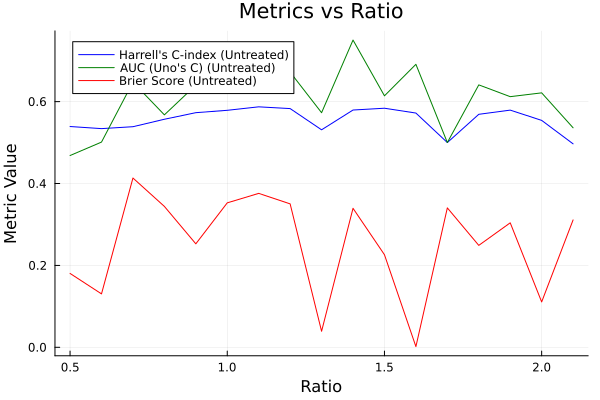

In [65]:
using CSV
using DataFrames
using Plots

# Define the ratio range
ratio_range = 0.5:0.1:2.1

# Initialize arrays to store metrics for untreated and treated cohorts
harrell_C_untreated_values = Float64[]
auc_untreated_values = Float64[]
brier_score_untreated_values = Float64[]

harrell_C_treated_values = Float64[]
auc_treated_values = Float64[]
brier_score_treated_values = Float64[]

# Iterate over each ratio
for ratio in ratio_range
    # Read the CSV file for the current ratio
    file_path = "traindata/matched_train_model3_ratio$(ratio).csv"
    data_cleaned = CSV.read(file_path, DataFrame)
    
    # Exclude risk_proba, chemo, OS, OSstatus columns
    X_cleaned = select(data_cleaned, Not([:dying_prob_5y, :risk_bucket, :adjuvantchemo, :died, :time_to_event]))
    y_cleaned = data_cleaned.died .== 1
    t_cleaned = data_cleaned.time_to_event ./ 30.44
    
    # Train on untreated matched patient
    X_cleaned_untreated = X_cleaned[data_cleaned.adjuvantchemo .== 0, :]
    y_cleaned_untreated = y_cleaned[data_cleaned.adjuvantchemo .== 0]
    t_cleaned_untreated = t_cleaned[data_cleaned.adjuvantchemo .== 0]
    println("Training Model 3A for ratio: ", ratio)
    tree3A = fit_learner("Model 3A", X_cleaned_untreated, y_cleaned_untreated, t_cleaned_untreated)
    # Create model names
    model_name_A = "Model 3A r=" * string(ratio)
    
    # Evaluate and record scores for untreated data
    train_auc_untreated = IAI.score(tree3A, train_X, train_y_untreated, val_t_untreated, criterion = :auc, evaluation_time = 5 * 12)
    test_harrell_untreated = IAI.score(tree3A, train_X, train_y_untreated, val_t_untreated, criterion = :harrell_c_statistic)
    test_brier_untreated = IAI.score(tree3A, train_X, train_y_untreated, val_t_untreated, criterion = :integratedbrier)
    push!(auc_untreated_values, train_auc_untreated)
    push!(brier_score_untreated_values, test_brier_untreated)
    push!(harrell_C_untreated_values, test_harrell_untreated)
    
    
end

# Plotting the metrics
plot(ratio_range, harrell_C_untreated_values, label = "Harrell's C-index (Untreated)", xlabel = "Ratio", ylabel = "Metric Value", title = "Metrics vs Ratio", color = :blue)
plot!(ratio_range, auc_untreated_values, label = "AUC (Uno's C) (Untreated)", color = :green)
plot!(ratio_range, brier_score_untreated_values, label = "Brier Score (Untreated)", color = :red)
